In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap

%matplotlib notebook

import project as proj
# import pointnets as ptn

np.set_printoptions(linewidth=120)

In [2]:
dataset = trn.get_dataset('3dshapes', labeled=True)
len(dataset)

Loading dataset: 3dshapes
dataroot: C:\Users\anwan\Documents\workspace\local_data
load_memory: True (by default)
train: True (by default)
labeled: True
label_type: class (by default)
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Found FID Stats


384000

tensor([ 0.3000,  0.6000,  0.1000,  0.7500,  1.0000, 25.7143])

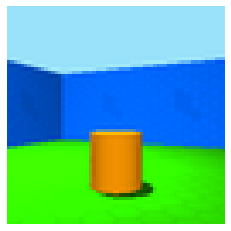

In [55]:
x,y = dataset[10]
plt.figure()
plt.imshow(x.permute(1,2,0))
plt.axis('off')
y

In [56]:
dataset.labels.shape

torch.Size([384000, 6])

In [3]:
# imgs = dataset.images.clone()
lbls = dataset.labels.clone()

In [4]:
lbls[:10]

tensor([[ 3,  4,  4,  1,  3,  4],
        [ 3,  6,  7,  3,  1,  0],
        [ 5,  3,  5,  0,  3,  3],
        [ 7,  7,  1,  1,  1,  2],
        [ 6,  3,  8,  3,  0, 14],
        [ 5,  5,  4,  6,  2, 12],
        [ 6,  6,  2,  3,  0, 13],
        [ 7,  4,  8,  7,  0,  9],
        [ 8,  2,  2,  3,  0, 14],
        [ 7,  8,  8,  0,  0, 13]], dtype=torch.int32)

In [6]:
dataset.factor_num_values

{'floor_hue': 10,
 'wall_hue': 10,
 'object_hue': 10,
 'scale': 8,
 'shape': 4,
 'orientation': 15}

In [4]:
len(lbls)

384000

In [10]:
torch.tensor(dataset.factor_sizes).float()

tensor([10., 10., 10.,  8.,  4., 15.])

In [5]:
lbls.max(0)[0], lbls.min(0)[0]

(tensor([ 0.9000,  0.9000,  0.9000,  1.2500,  3.0000, 30.0000]),
 tensor([  0.0000,   0.0000,   0.0000,   0.7500,   0.0000, -30.0000]))

In [13]:
lbls -= lbls.min(0, keepdim=True)[0]
lbls *= ((torch.tensor(dataset.factor_sizes).float()-1) / lbls.max(0, keepdim=True)[0])
lbls.max(0)[0]

tensor([ 9.,  9.,  9.,  7.,  3., 14.])

In [17]:
lbls[:10].int()

tensor([[ 3,  4,  4,  1,  3,  4],
        [ 3,  6,  7,  3,  1,  0],
        [ 5,  3,  5,  0,  3,  3],
        [ 7,  7,  1,  1,  1,  2],
        [ 6,  3,  8,  3,  0, 14],
        [ 5,  5,  4,  6,  2, 12],
        [ 6,  6,  2,  3,  0, 13],
        [ 7,  4,  8,  7,  0,  9],
        [ 8,  2,  2,  3,  0, 14],
        [ 7,  8,  8,  0,  0, 13]], dtype=torch.int32)

In [94]:
sel = lbls[:,4] != 2
sel.sum()

tensor(287990)

In [95]:
inds = torch.arange(len(lbls))[sel]
inds = inds.numpy()
np.random.shuffle(inds,)
inds = torch.from_numpy(inds)
inds

tensor([ 84322,  35431, 316330,  ..., 255237, 259500, 129718])

In [96]:
picks = imgs[inds[:64]]
picks.shape

torch.Size([64, 3, 64, 64])

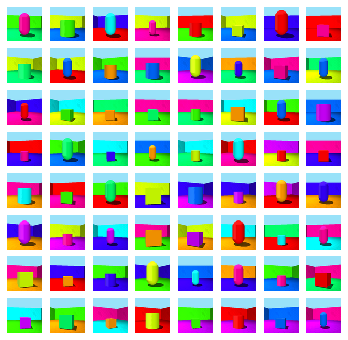

In [97]:
util.show_imgs(picks)
pass

In [2]:
C = trn.get_config('pycharm')
C

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


{{'device':'cuda', 'num_workers':0, 'seed':0, 'output':{{'tblog':True, 'txtlog':False, 'logdate':True, 'save_freq':5000, 'print_freq':200}}, 'training':{{'start':0, 'epochs':20, 'track_best':True, 'no_test':True, 'step_limit':100000, 'val_freq':5000, 'time_limit':2}}, 'dataset':{{'batch_size':128, 'shuffle':True, 'drop_last':True, 'name':'3dshapes', 'val_split':0.1, 'device':'cpu', 'category':'real'}}, 'model':{{'optim_type':'adam', 'lr':0.001, 'weight_decay':0, 'momentum':0, 'beta1':0.9, 'beta2':0.999, '_type':'ae', 'latent_dim':12, 'reg':'pow2', 'criterion':'bce', 'norm':None, 'nonlin':'elu', 'branch_dim':1, 'branch_hidden':t[64, 128], 'decoder':{{'_type':'branch-dec', 'root_dim':0, 'branch_type':'norm-ada-in', 'branches':{{'_type':'iter', 'output_nonlin':None, 'net':{{'_type':'mlp', 'hidden_dims':'<>branch_hidden'}}, '_elements':t[{{'_type':'<>branch_type'}}, {{'_type':'<>branch_type'}}, {{'_type':'<>branch_type'}}, {{'_type':'<>branch_type'}}, {{'_type':'<>branch_type'}}, {{'_type'

In [2]:
C = trn.get_config()
C.name = '3dshapes'
C._mod = 'trans'

C.device = 'cpu'
C.folds.train['4'] = [0,1]
C.folds.upd['4'] = [2]

C.mix.train = 1
C.mix.upd = 1

C

{{'name':'3dshapes', '_mod':'trans', 'device':'cpu', 'folds':{{'train':{{'4':t[0, 1]}}, 'upd':{{'4':t[2]}}}}, 'mix':{{'train':1, 'upd':1}}, '_ipython_canary_method_should_not_exist_':{{}}}}

In [3]:
dataset = trn.default_load_data(C)
len(dataset)

dataroot: C:\Users\anwan\Documents\workspace\local_data
load_memory: True (by default)
train: True (by default)
labeled: False (by default)
label_type: class (by default)
noise: None (by default)
din: (3, 64, 64) (by default)
dout: (3, 64, 64) (by default)
Found FID Stats
  folds (type=dict): 
    (train) (type=dict): 
      (4) (type=list): 
      [0]: 0
      [1]: 1
    (upd) (type=dict): 
      (4) (type=list): 
      [0]: 2
default_fold: train (by default)
fold_by: index (by default)
  mix (type=dict): 
  (train): 1
  (upd): 1
Found 2 folds: train, upd
{'train': {4: [0, 1]}, 'upd': {4: [2]}} torch.Size([384000, 6])
Dataset moved to cpu


192020

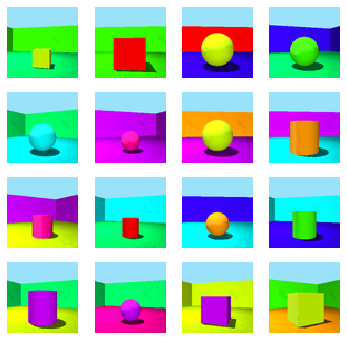

In [11]:
util.show_imgs(dataset[torch.randperm(len(dataset))[:16]][0])
pass

In [12]:
dataset.mix

{'upd': 960100, 'train': 96010}

In [10]:
dataset.set_mix(upd=10, train=1)
len(dataset)

192020

In [13]:
dataset.folds

{'train': tensor([     1,      3,      4,  ..., 383992, 383994, 383996]),
 'upd': tensor([     5,     20,     23,  ..., 383997, 383998, 383999])}

In [14]:
{k:v.shape for k,v in dataset.folds.items()}

{'train': torch.Size([192115]), 'upd': torch.Size([96010])}

In [42]:
dataset = trn.default_load_data(C.dataset)
len(dataset)

dataroot: C:\Users\anwan\Documents\workspace\local_data
load_memory: True (by default)
train: True
labeled: False (by default)
noise: None (by default)
din: (3, 64, 64) (by default)
dout: (3, 64, 64) (by default)
Found FID Stats
mode: train
  mechanisms (type=dict): 
    (train) (type=list): 
    [0]: floor_hue
    [1]: wall_hue
    [2]: object_hue
    [3]: scale
    [4]: orientation
    (update) (type=list): 
    [0]: object_hue
    [1]: floor_hue
    [2]: wall_hue
    [3]: scale
    [4]: orientation
    [5]: shape
    (test) (type=list): 
    [0]: object_hue
    [1]: floor_hue
    [2]: wall_hue
    [3]: scale
    [4]: orientation
    [5]: shape
Mechanisms: (current mode: train): ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'orientation']
default_class: middle (by default)
name: 3dshapes
Dataset moved to cpu


96010

In [43]:
# dataset = trn.get_dataset('mpi3d', labeled=True, category='complex')
# len(dataset)

40709

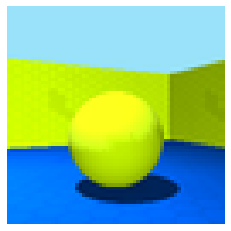

In [66]:
idx = np.random.randint(len(dataset))
x, = dataset[idx]
plt.figure()
plt.imshow(x.permute(1,2,0))
plt.axis('off')
#y, ' '.join(map(str, [dataset.factor_values[name][i] for name, i in zip(dataset.factor_order, y)]))
idx

In [5]:
ind = dataset.indices[idx]
ind

tensor(234338)

In [6]:
dataset.get_label(ind.numpy())

array([ 2,  0,  0,  0,  2, 18, 18], dtype=int32)

In [7]:
dataset._flr

array([115200,  28800,  14400,   4800,   1600,     40,      1], dtype=int32)

In [27]:
' '.join(map(str, [dataset.factor_values[name][i] for name, i in zip(dataset.factor_order, y)]))

'olive cup large top sea_green 1 32'

In [37]:
flr = dataset._flr
flr

array([115200,  28800,  14400,   4800,   1600,     40,      1], dtype=int32)

In [45]:
inds = dataset.indices.clone()
len(inds), inds[:20]

(368640,
 tensor([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 19, 21,
         22, 23]))

In [48]:
A = inds[:100]

In [50]:
A % 10

tensor([0, 1, 2, 3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 9, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 3, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 2, 3, 4, 5, 6,
        7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0,
        1, 2, 3, 4, 5, 6, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7,
        9, 0, 1, 2])

In [53]:
l = torch.linspace(0.75,1.25,10)
l

tensor([0.7500, 0.8056, 0.8611, 0.9167, 0.9722, 1.0278, 1.0833, 1.1389, 1.1944,
        1.2500])

In [54]:
torch.isclose(l, 0.8056)

TypeError: isclose(): argument 'other' (position 2) must be Tensor, not float

In [28]:
root = 'c:/Users/anwan/Documents/workspace/local_data'

In [29]:
dataroot = os.path.join(root, 'mpi3d')
os.listdir(dataroot)

['mpi3d_complex_test.h5',
 'mpi3d_complex_train.h5',
 'mpi3d_realistic_stats_fid.pkl',
 'mpi3d_realistic_test.h5',
 'mpi3d_realistic_train.h5',
 'mpi3d_real_stats_fid.pkl',
 'mpi3d_real_test.h5',
 'mpi3d_real_train.h5',
 'mpi3d_toy_stats_fid.pkl',
 'mpi3d_toy_test.h5',
 'mpi3d_toy_train.h5',
 'real3d_complicated_shapes_ordered.npz']

In [36]:
data = np.load(os.path.join(dataroot, 'real3d_complicated_shapes_ordered.npz'))
list(data.keys())

['images']

In [37]:
raw = data['images']
raw.shape

(460800, 64, 64, 3)

In [38]:
idx = 131918


In [39]:
stepsize = 1 * 40 * 40 * 3 * 3 * 2 #* 4 #* 4
# 40 40 3 3 2 4 4
# vertical, horizontal, color bg, cam angle, size, shape, color

(131918, 4)

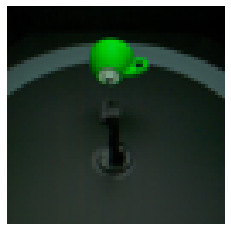

In [40]:
# idx += stepsize
plt.figure()
plt.imshow(raw[idx])
plt.axis('off')
idx, idx // stepsize